In [433]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import sys
import pprint
import random
import xml.etree.ElementTree as ET

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

We start off by shamelessly stealing the general structure of our solutiou out of the lab.

In [434]:
Vertex = namedtuple('Vertex', ['id', 'x', 'y', 'order'])

In [435]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

In [436]:
def fitness(vertices, distance, solution, lower_car_limit):
    solution_distance = 0
    # Punish using more cars than is possible
    used_cars = 0
    for x, y in zip(solution, solution[1:]):
        if x == solution[-1] and lower_car_limit >= used_cars:
            solution_distance += 1
        elif x == solution[-1]:
            solution_distance += 100
        solution_distance += distance(vertices[x], vertices[y])
    return solution_distance

In [437]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

In [438]:
def generate_solutions(vertices, pheromones, distance, N, ant_capacity, alpha=1, beta=3):
    
    def compute_prob(v1, v2, left_to_deliver, carrying=0):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        if left_to_deliver[v2] == 0 or carrying < left_to_deliver[v2]:
            ret = ret/2
        else:
            ret *= 2
        return ret if ret > 0.000001 else 0.000001
    
    

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        left_to_deliver = 0
        left_to_deliver_list = []
        for vertex in vertices:
            left_to_deliver += vertex[3]
            left_to_deliver_list.append(vertex[3])
        available = list(range(pheromones_shape))
        carrying = ant_capacity
        # The depo vertex is always last
        solution = [pheromones_shape-1]
        available.remove(solution[0])
        while available:
            # Go back to pick up more cargo
            if carrying == 0:
                solution.append(pheromones_shape-1)
                carrying = ant_capacity
            # We fulfilled all orders, go straight home
            elif left_to_deliver == 0:
                solution.append(pheromones_shape-1)
                available.clear()
            else:
                probs = np.array(list(map(lambda x: compute_prob(solution[-1], x, carrying=carrying, left_to_deliver=left_to_deliver_list), available)))
                selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
                solution.append(selected)

                fulfilled_amount = min(carrying, left_to_deliver_list[selected])
                carrying -= fulfilled_amount
                left_to_deliver_list[selected] -= fulfilled_amount
                left_to_deliver -= fulfilled_amount

                # This can probably prevent some optimal solutions, but we may need to return to an unfulfilled order
                if left_to_deliver_list[selected] == 0 and selected != pheromones_shape - 1:
                    available.remove(selected)
                if not available:
                    if solution[-1] != pheromones_shape-1:
                        solution.append(pheromones_shape-1)
        yield solution

In [439]:
def ant_solver(vertices, distance, ants=10, ant_capacity=100, max_iterations=1000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')

    should_use_cars = 0
    for vertex in vertices:
            should_use_cars += vertex[3]
    should_use_cars = np.ceil(should_use_cars/ant_capacity)
    
    for i in range(max_iterations):
        solutions = list(generate_solutions(vertices, pheromones=pheromones, distance=distance, N=ants, ant_capacity=ant_capacity, alpha=alpha, beta=beta))
        fits = list(map(lambda x: fitness(vertices, distance, x, should_use_cars), solutions))
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

In [440]:
def read_xml_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    nodes = root.find('network').find('nodes')
    fleet = root.find('fleet')
    requests = root.find('requests')

    paired_requests = {}
    verticies = []
    depo = None

    for request in requests.findall('request'):
        node = int(request.get('node'))
        found = paired_requests.get(node, 0)
        paired_requests[node] = found+float(request.find('quantity').text)
    
    for node in nodes.findall('node'):
        type_of_node = int(node.get('type'))
        id = int(node.get('id'))
        
        if type_of_node == 1:
            verticies.append(Vertex(id, float(node.find('cx').text), float(node.find('cy').text), paired_requests.get(id, 0)))
        else:
            depo = Vertex(id, float(node.find('cx').text), float(node.find('cy').text), 0)
    
    capacity = float(fleet.find('vehicle_profile').find('capacity').text)
    return verticies, depo, capacity, paired_requests

In [441]:
def draw_result(vertices, pheromones, best_solution):
    lines = []
    colors = []
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            lines.append([(v1.x, v1.y), (v2.x, v2.y)])
            colors.append(pheromones[i][j])

    lc = mc.LineCollection(lines, linewidths=np.array(colors))

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.add_collection(lc)
    ax.autoscale()

    solution = best_solution

    # tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
    # solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

    print('Fitness: ', fitness(vertices, distance, solution, sys.maxsize))

    solution_vertices = [vertices[i] for i in solution]
    # pprint.pprint(solution_vertices)

    solution_lines = []
    for i, j in zip(solution, solution[1:]):
        solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
    # solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
    solutions_lc = mc.LineCollection(solution_lines, colors='red')
    ax.add_collection(solutions_lc)

In [442]:
vertices, depo, capacity, paired_requests = read_xml_data('data/data_422.xml')
vertices.append(depo)
# Make the depo always the last vertex so that we don't have to rewrite the lab code too much
best_solution, pheromones = ant_solver(vertices = vertices, distance = distance, max_iterations=500, ant_capacity=capacity)
print(best_solution)
print('Min distance, Mean distance, Max distance')

   0, 3351.2059, 3504.2710, 3755.9875
   1, 3045.5066, 3338.2573, 3610.5499
   2, 3001.7266, 3319.1155, 3525.5056
   3, 3175.2194, 3462.3692, 3751.3198
   4, 3244.1713, 3529.8551, 3728.6856
   5, 3441.2948, 3554.7823, 3695.8399
   6, 3353.4648, 3601.7807, 3857.5613
   7, 3200.1433, 3526.4599, 3809.8486
   8, 3337.0412, 3656.9623, 3908.0633
   9, 3361.3961, 3667.1574, 3946.7894
  10, 3447.7962, 3587.2038, 3924.9405
  11, 3474.0819, 3721.0010, 3886.0746
  12, 3398.2950, 3727.2576, 3965.8260
  13, 3477.3346, 3796.7396, 4065.8961
  14, 3484.0858, 3751.9313, 3926.6062
  15, 3358.2061, 3641.0606, 3866.3574
  16, 3336.4626, 3674.3500, 4112.6121
  17, 3322.8334, 3740.0644, 4033.6152
  18, 3333.6044, 3643.0068, 3997.9324
  19, 3414.8253, 3609.5116, 3828.8318
  20, 3265.8043, 3621.8907, 3956.8891
  21, 3322.9830, 3621.8376, 3929.6629
  22, 3452.6373, 3596.1233, 3884.5537
  23, 3222.1041, 3655.8016, 3863.8993
  24, 3252.4656, 3497.3188, 3705.4358
  25, 3307.2671, 3620.1830, 4068.4521
  26, 3195.3

Fitness:  2768.1004998227104


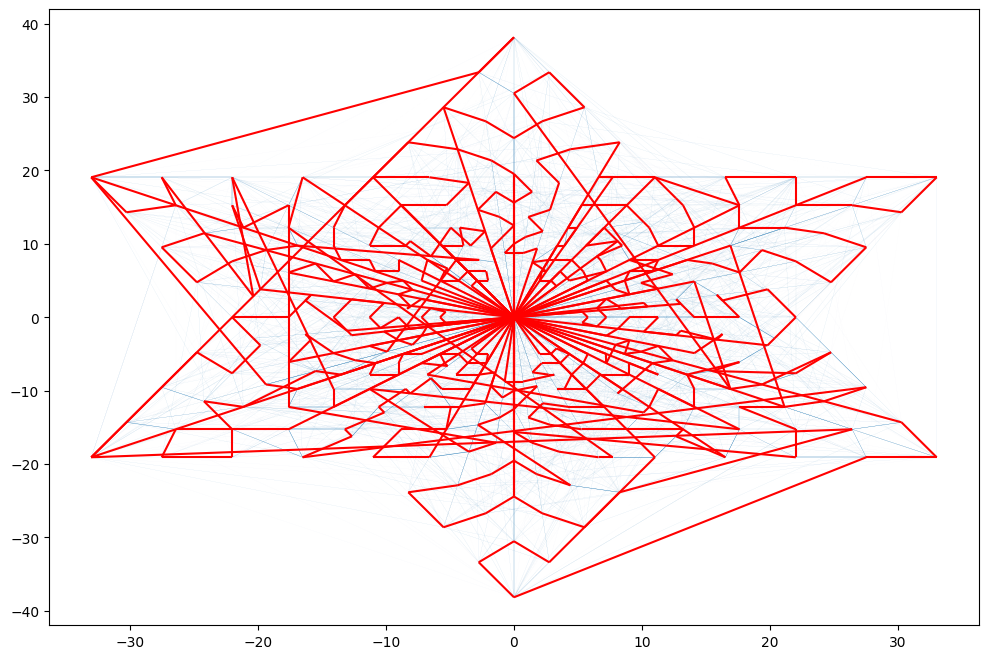

In [443]:
draw_result(vertices=vertices, pheromones=pheromones, best_solution=best_solution)